# Tutorial 22: Data-driven corrections in SUP-ROM

In this tutorial, new data-driven corrections are introduced in the supremizer formulation.
The case considered is the flux around a circular cylinder.

## Data collection: offline stage

The first step is to run the Openfoam simulation and to find the POD modes for velocity, supremizer and pressure fields. In this case we consider the supremizer formulation, so run on terminal: *offline 'supremizer'*.

In this way the folder 'ITHACAoutput' is created. Snapshots data are collected in 'ITHACAoutput/Offline'. The matrices used to assemble the reduced systems are stored in 'ITHACAoutput/Matrices'. The POD modes for velocity and pressure are stored in 'ITHACAoutput/POD', whereas supremizer modes are collected in 'ITHACAoutput/supremizer'.

## Definition of the SUP-ROM dynamical system: online stage

We import useful modules:

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
import os
from DD_SUP_ROM import SUP_ROM
from sklearn import *

The reference folder from which data is extracted is also defined.

In [2]:
folder = './ITHACAoutput'

Now the SUP_ROM class is used to define the different dynamical systems which should be solved and compared in the online phase.

We here choose a reduced number of velocity, supremizer and pressure modes ($N_u, N_{sup}$ and $N_p$, respectively) for the reduced model. The modes are denoted as: $(\boldsymbol{\phi_i})_{i=1}^{N_u+N_{sup}}$ and $(\chi_i)_{i=1}^{N_p}$.

In [3]:
Nu = 5
Nsup = 5
Np = 5
Nnut = 5
nu = 1e-4  #viscosity

The reduced approximated fields are computed at each time step by solving a dynamical system with unknowns $\mathbf{a}=(a_i)_{i=1}^{N_u+N_{sup}}$ and $\mathbf{b}=(b_i)_{i=1}^{N_p}$, which are the vectors of coefficients for velocity and pressure. The reduced approximated fields are defined as:
\begin{equation}
\mathbf{u}_r = \sum_{i=1}^{N_u+N_{sup}} a_i(t) \boldsymbol{\phi_i} \text{ and } \bar{p}_r = \sum_{i=1}^{N_u+N_{sup}} b_i(t) \chi_i
\end{equation}

Now the supremizer reduced dynamical system, i.e. without any correction term and without turbulence modelling, is defined as follows:
\begin{equation}
    \begin{cases}
    \mathbf{M} \dot{\mathbf{a}}=\nu(\mathbf{B}+\mathbf{B_T})\mathbf{a}-\mathbf{a}^T \mathbf{C} \mathbf{a}-\mathbf{H}\mathbf{b}+\tau \left( \sum_{k=1}^{N_{\text{BC}}}(U_{\text{BC},k}\mathbf{D}^k-\mathbf{E}^k \mathbf{a})\right) ,\\
    \mathbf{P}\mathbf{a}=\mathbf{0}.
    \end{cases}
\end{equation}

Matrices appearing in the previous system are defined as:
\begin{equation}
\begin{split}
&(\mathbf{M})_{ij}=(\boldsymbol{\phi}_i,\boldsymbol{\phi}_j)_{L^2(\Omega)}, \quad (\mathbf{P})_{ij}=(\chi_i,\nabla \cdot \boldsymbol{\phi}_j)_{L^2(\Omega)}\, ,\quad (\mathbf{B})_{ij}=(\boldsymbol{\phi}_i,\nabla \cdot \nabla \boldsymbol{\phi}_j)_{L^2(\Omega)}, \\
&(\mathbf{B_T})_{ij}=(\boldsymbol{\phi}_i,\nabla \cdot (\nabla \boldsymbol{\phi}_j)^T)_{L^2(\Omega)},\quad (\mathbf{C})_{ijk}=(\boldsymbol{\phi}_i,\nabla \cdot (\boldsymbol{\phi}_j \otimes \boldsymbol{\phi}_k))_{L^2(\Omega)}, \quad (\mathbf{H})_{ij}=(\boldsymbol{\phi}_i,\nabla \chi_j)_{L^2(\Omega)}\, .
\end{split}
\end{equation}

The term $\tau \left( \sum_{k=1}^{N_{\text{BC}}}(U_{\text{BC},k}\mathbf{D}^k-\mathbf{E}^k \mathbf{a})\right)$ is a penalization term used to enforce the Dirichlet boundary conditions at the reduced order level. In particular, $N_{\text{BC}}$ is the number of velocity boundary conditions on $k $ different parts of the Dirichlet boundary; $U_{\text{BC},k}$ is the velocity non-zero component at the $k$-th part of the Dirichlet boundary; $\tau$ is a penalization factor, matrices $\mathbf{E}^k$ and vectors $\mathbf{D}^k$ are defined as:
\begin{equation} (\mathbf{E}^k)_{ij}=(\boldsymbol{\phi}_i, \boldsymbol{\phi}_j)_{L^2(\Gamma_{D_k})}, \quad (\mathbf{D}^k)_{i}=(\boldsymbol{\phi}_i)_{\Gamma_{D_k}}, \text{ for all }k=1,...,N_{\text{BC}}.\end{equation}

The time derivative is computed with a second order backward time scheme.

This system is solved at each time step, lasting 0.004 seconds, for 501 time steps, for a global online computational time of 2 seconds.

In [4]:
ROM_case_stand = SUP_ROM(folder, Nu, Nsup, Np, 0, 0)
ROM_case_stand.solveOnline_standard(0.004,501)
ROM_case_stand.errors()

The projections of the full order fields onto the subspace generated by these modes are:

\begin{equation}
\mathbf{\bar{u}}_r = \sum_{i=1}^{N_u+N_{sup}} a^{snap}_i \boldsymbol{\phi_i} \text{ and } \bar{p}_r = \sum_{i=1}^{N_u+N_{sup}} b^{snap}_i \chi_i,
\end{equation}
where the matrices of the coefficients $a^{snap}_i$ and $b^{snap}_i$ are evaluated from the POD and stored in the snapshots matrices *snapU*, *snapSup* and *snapP*.

*U_proj* and *P_proj* compute the reconstruction percentage errors, which are defined as the errors of the projected fields and the full order solutions and represent the best possible result that can be achieved.

In [5]:
U_err_proj = ROM_case_stand.U_proj()
P_err_proj = ROM_case_stand.P_proj()

Now the supremizer reduced system with the addition of extra correction terms is defined:
\begin{equation}
    \begin{cases}
    \mathbf{M} \dot{\mathbf{a}}=\nu(\mathbf{B}+\mathbf{B_T})\mathbf{a}-\mathbf{a}^T \mathbf{C} \mathbf{a}-\mathbf{H}\mathbf{b}+\tau \left( \sum_{k=1}^{N_{\text{BC}}}(U_{\text{BC},k}\mathbf{D}^k-\mathbf{E}^k \mathbf{a})\right) + \boldsymbol{\tau}_u(\mathbf{a}),\\
    \mathbf{P}\mathbf{a}=\mathbf{0}.
    \end{cases}
\end{equation}


In the first equation the term $\boldsymbol{\tau^u}(\mathbf{a})$ is a velocity correction term evaluated as follows.

1. First of all, the exact correction term is found from available data, at each time step:

$\boldsymbol{\tau}_u^{\text{exact}}(t_j)=\left(- \overline{(\mathbf{a}_d^{snap}(t_j))^T\mathbf{C_d}\mathbf{a}_d^{snap}(t_j)}^r\right) -\left(-(\mathbf{a}_r^{snap}(t_j))^T\mathbf{C}\mathbf{a}_r^{snap}(t_j) \right)\, , $
where the tensor $\mathbf{C_d} \in \mathbb{R}^{d \times d \times d}$ is defined in the following way:
$
\mathbf{C_d}_{\,ijk}=\left(\boldsymbol{\phi}_i, \nabla \cdot (\boldsymbol{\phi}_j \otimes \boldsymbol{\phi}_k) \right).
$

2. Then, an ansatz is proposed to model the approximated correction term:

\begin{equation}
\boldsymbol{\tau}_u^{\text{ansatz}}(t_j)=\tilde{A}\mathbf{a}(t_j)+(\mathbf{a}(t_j))^T\tilde{B}\mathbf{a}(t_j),
\end{equation}
where the unknwons are matrices $\tilde{A}$ and $\tilde{B}$.

3. The matrices and tensors appearing in the ansatz are computed by solving an optimization problem, which is rewritten as a least squares problem between the exact and the approximated term. In this tutorial, we are considering a costrained least squares problem, with physical energetical constraints.

\begin{equation}
    \min_{\substack{\tilde{A} \in \mathbb{R}^{r \times r},\\ \tilde{B} \in \mathbb{R}^{r \times r \times r},\\ \mathbf{a} \tilde{A} \mathbf{a} \leq 0,\\\mathbf{a}^T(\mathbf{a}^T \tilde{B} \mathbf{a})=0}}{\sum_{j=1}^{M_1} || \boldsymbol{\tau}_u^{\text{exact}}(t_j)-\boldsymbol{\tau}_u^{\text{ansatz}}(t_j)||_{L^2(\Omega)}^2} .
\end{equation}

It is important to remark that the number of time steps used to compute the correction terms is 500 (2 seconds), whereas the online simulation lasts 5001 time steps (8 seconds). 

The least squares problem which is obtained is written in the following way:

\begin{equation}
    \min_{\mathbf{O}}{||\mathbf{R}-\mathbf{D}\mathbf{O}^T||^2_F} ,
\end{equation}
where:
\begin{equation}
\mathbf{R}_{j,\cdot}=\mathbf{\tau_u}^{\text{exact}}(t_j) \quad \forall j=1,...M, \quad \mathbf{O}=[\tilde{A},\tilde{B}^{(1)}, \tilde{B}^{(2)},...,\tilde{B}^{(r)}], \text{ with } \tilde{B}^{(i)} \text{ i-th blocks of tensor } \tilde{B},
\end{equation}
\begin{equation}
\mathbf{D}=[\hat{X}, \hat{X}^{(1)}, \hat{X}^{(2)},..., \hat{X}^{(r)}], \text{ with:} 
\end{equation}
- $\hat{X}_{j,\cdot}=\mathbf{a}_r^{\text{snap}}(t_j)$, which is the j-th row of matrix $\hat{X}$;
- $\mathbf{a}^{(i)}(t_j)=a^{\text{snap}}_i(t_j) \begin{bmatrix}a_0^{\text{snap}}(t_j)\\a_1^{\text{snap}}(t_j)\\...\\a_i^{\text{snap}}(t_j)
    \end{bmatrix} \in \mathbb{R}^i \text{ for }i=1,...,r$;
- $\hat{X}^{(i)}_{j,\cdot}=\mathbf{a}^{(i)}(t_j)$, which is the j-th row of matrix $\hat{X}^{(i)}$, with $i=1,...,r$.

Matrix $\mathbf{D}$ in the least squares problem is ill-conditioned and in order to solve this problem a truncated singular value decoposition is applied to the matrix. The number of singular values retained in this truncated SVD ($Ru$) is chosen at the one that optimizes a velocity error metric $\varepsilon_u$ *a posteriori*. The error metric considered is:

\begin{equation}
    \varepsilon_u (L^2)= \sum_{j=1}^M ||\mathbf{u}_{\text{sol}}(t_j)-\mathbf{u}_r(t_j)||_{L^2(\Omega)} ,
    \label{error_metric}
\end{equation}
where $M$ is the number of time steps considered for the online simulation (2000 in our case, which corresponds to 8 seconds).

In [10]:
Ru = 6
ROM_case = SUP_ROM(folder, Nu, Nsup, Np, 0, Ru)
ROM_case.solveOnline(0.004,501)

Now the formulation including the turbulence modelling is defined.
In this formulation, there is an extra-term depending on the eddy viscosity $\nu_t$, which is modelled as a linear combination of eddy viscosity modes $(\eta_i)_{i=1}^{N_{\nu_t}}$. The reduced eddy viscosity field is expressed as:

\begin{equation}
\nu_{t, r} = \sum_{i=1}^{N_{\nu_t}} g_i(t) \eta_i
\end{equation}

The reduced number of modes chosen for the eddy viscosity is the same of the velocity modes in our case ($N_{\nu_t}=N_u$). 

The reduced vector of coefficients $\mathbf{g}=(g_i)_{i=1}^{N_{\nu_t}}$ is computed at each time step with a regression technique starting from vector $\mathbf{a}$. 
In this case, $\mathbf{g}$ is computed making use of a feed-forward neural network, which is trained with the pairs of snapshots $(\mathbf{a}^{snap}, \mathbf{g}^{snap})$.

The reduced system written before can be rewritten in the following way:
\begin{equation}
\begin{cases}
    &\mathbf{M}\dot{\mathbf{a}} = \nu (\mathbf{B}+\mathbf{B_T}) \mathbf{a} - \mathbf{a}^T \mathbf{C} \mathbf{a} + \mathbf{g}^T (\mathbf{C}_{\text{T1}}+\mathbf{C}_{\text{T2}}) \mathbf{a} - \mathbf{H} \mathbf{b}+\tau \left( \sum_{k=1}^{N_{\text{BC}}}(U_{\text{BC},k}\mathbf{D}^k-\mathbf{E}^k \mathbf{a})\right) + \boldsymbol{\tau}^u(\mathbf{a}) \, ,\\
    &\mathbf{P} \mathbf{a}=\mathbf{0} \, ,
    \end{cases}
\end{equation}
where the new tensors are defined as follows.
\begin{equation}
    \begin{cases}
    &(\mathbf{C}_{\text{T1}})_{ijk}=(\boldsymbol{\phi}_i, \eta_j \nabla \cdot \nabla \boldsymbol{\phi}_k)_{L^2(\Omega)} \, ,\\
    &(\mathbf{C}_{\text{T2}})_{ijk}=(\boldsymbol{\phi}_i, \nabla \cdot \eta_j (\nabla \boldsymbol{\phi}_k)^T)_{L^2(\Omega)}\, .
    \end{cases}
\end{equation}

The number of singular values retained in this case is called $Ru\_T$.

In [11]:
Ru_T = 7
ROM_caseT = SUP_ROM(folder, Nu,Nsup,Np,Nnut,Ru_T)
ROM_caseT.train_w([400,100],1500,500,1e-5, nn.ReLU) #training of neural network
ROM_caseT.solveOnlineT(0.004,501) #solve the dynamical system

The *errors* corresponding to each ROM case are here evaluated. This method calculates the percentage errors of the reduced velocity and pressure fields, at each time step, in the $L^2$ norm, with respect to the projected fields and the full order fields.

In [12]:
ROM_cases = [ROM_case, ROM_caseT, ROM_case_stand]
for case in ROM_cases:
    case.errors()

Below the plots of the errors of the different cases with respect to the full order fields are represented, for both the velocity and the pressure fields.

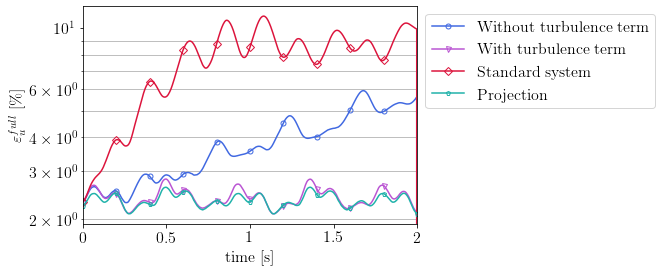

In [14]:
colors = ["royalblue","mediumorchid","crimson","lightseagreen","navy"]
markers = ["o","v","D","p","s"]
figvel = plt.figure()
ax = figvel.add_subplot(111)
plt.plot(ROM_case.errU_full, color=colors[0],marker=markers[0],markersize=5,markevery=50,label=r'Without turbulence term', fillstyle='none')
plt.plot(ROM_caseT.errU_full, color=colors[1],marker=markers[1],markersize=5,markevery=50,label=r'With turbulence term', fillstyle='none')
plt.plot(ROM_case_stand.errU_full, color=colors[2],marker=markers[2],markersize=5,markevery=50,label=r'Standard system', fillstyle='none')
plt.plot(U_err_proj, color=colors[3],marker=markers[3],markersize=5,markevery=50,label=r'Projection', fillstyle='none')
plt.ylabel(r'$\varepsilon_u^{full}$ [$\%$]')
ax.set_xticks([0,125,250,375,500])#,750,1000,1250,1500,1750,2000])
ax.set_xticklabels([0,0.5,1,1.5,2])#,3,4,5,6,7,8])
ax.set_xlabel('time [s]')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xlim(0,500)
plt.yscale("log")
plt.grid(True, which="both", ls="-")
plt.grid()
plt.show()
figvel.savefig("error_U_SUP.pdf",bbox_inches='tight')

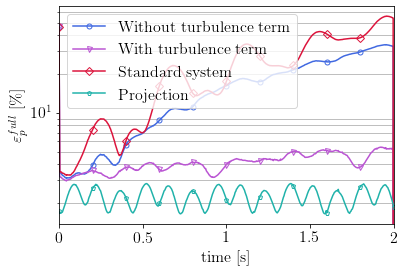

In [15]:
figp=plt.figure()
ax = figp.add_subplot(111)
plt.plot(ROM_case.errP_full, color=colors[0],marker=markers[0],markersize=5,markevery=50,label=r'Without turbulence term', fillstyle='none')
plt.plot(ROM_caseT.errP_full, color=colors[1],marker=markers[1],markersize=5,markevery=50,label=r'With turbulence term', fillstyle='none')
plt.plot(ROM_case_stand.errP_full, color=colors[2],marker=markers[2],markersize=5,markevery=50,label=r'Standard system', fillstyle='none')
plt.plot(P_err_proj, color=colors[3],marker=markers[3],markersize=5,markevery=50,label=r'Projection', fillstyle='none')
plt.ylabel(r'$\varepsilon_p^{full}$ [$\%$]')
ax.set_xticks([0,125,250,375,500])#,750,1000,1250,1500,1750,2000])
ax.set_xticklabels([0,0.5,1,1.5,2])#,3,4,5,6,7,8])
ax.set_xlabel('time [s]')
plt.legend()
plt.xlim(0, 500)
plt.yscale("log")
plt.grid(True, which="both", ls="-")
plt.grid()
plt.show()
figp.savefig("error_P_SUP.pdf",bbox_inches='tight')